In [20]:
%matplotlib inline
import torch
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
tcd = torch.distributions
torch.set_default_dtype(torch.float64) #without it we have underflow and we can encounter problems
sns.set_theme()

# Data

<AxesSubplot:>

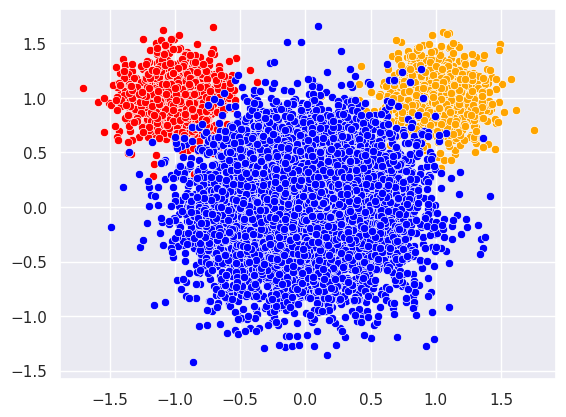

In [21]:
var_ear=0.2**2
var_head=0.4**2
left_ear = tcd.MultivariateNormal(torch.tensor([-1,1]).double(),var_ear*torch.eye(2))
right_ear = tcd.MultivariateNormal(torch.tensor([1,1]).double(),var_ear*torch.eye(2))
head= tcd.MultivariateNormal(torch.tensor([0,0]).double(),var_head*torch.eye(2))
N=10000
p=0.8
a = left_ear.sample(torch.Size([int(N*(1-p)/2)]))
b = right_ear.sample(torch.Size([int(N*(1-p)/2)]))
c = head.sample(torch.Size([int(N*p)]))
data = torch.cat((a, b, c))
sns.scatterplot(x=a[:,0],y=a[:,1],color="red")
sns.scatterplot(x=b[:,0],y=b[:,1],color="orange")
sns.scatterplot(x=c[:,0],y=c[:,1],color="blue")

# Initialization

In [22]:
def initialize(n):
    mu = torch.rand([n, 2]) * 4 - 2
    sigma = torch.rand([n, 2, 2])
    sigma = torch.matmul(sigma, torch.transpose(sigma, 1, 2))+torch.eye(2)*0.0001
    pi = torch.rand(n)
    pi = pi / torch.sum(pi)
    return sigma, mu, pi

# Expectation

In [23]:
def expectation_GMM(n,pi,mu,sigma,data):
    dis = []
    for i in range(n):
        dis.append(tcd.MultivariateNormal(loc=mu[i],covariance_matrix=sigma[i]))
    wyn = torch.zeros(len(data),n)
    for i in range(n):
        wyn[:,i]=dis[i].log_prob(data)+torch.log(pi[i])
    wyn = torch.exp(wyn)
    for i in range(len(data)):
        wyn[i,:]=wyn[i,:]/torch.sum(wyn[i,:])
    return wyn

In [24]:
sigma, mu, pi = initialize(3)
print(pi)
print(mu)
print(sigma)

tensor([0.5867, 0.0703, 0.3430])
tensor([[-1.7739,  0.8019],
        [ 0.9312,  1.0556],
        [ 1.4899,  1.7286]])
tensor([[[0.4036, 0.2134],
         [0.2134, 0.1885]],

        [[1.7708, 0.3586],
         [0.3586, 0.1174]],

        [[0.5695, 0.1546],
         [0.1546, 0.2844]]])


# Maximalization

In [25]:
def maximalization(likelihood, data,min_var=1e-3,eps=1e-3):
    suma=torch.sum(likelihood,axis=0)
    pi = suma/len(data)
    mu = (torch.matmul(data.T,likelihood) / suma).T
    sigma=(torch.einsum("ij,ia,ib->jab",likelihood,data,data)+torch.einsum("ij,ja,jb->jab",likelihood,mu,mu)+
    (torch.einsum("ij,ia,jb->jab",likelihood,-data,mu)+torch.einsum("ij,ja,ib->jab",likelihood,-mu,data)))
    for j in range(len(pi)):
        sigma[j]/=(suma[j]+eps)
    sigma=torch.clamp(sigma, min=min_var)
    return pi,mu,sigma

In [26]:
for u in range(100):
    soft_reg=expectation_GMM(3,pi,mu,sigma,data)
    pi,mu,sigma=maximalization(soft_reg,data)

In [27]:
print(pi)
print(mu)
print(sigma)

tensor([0.0986, 0.1008, 0.8006])
tensor([[-1.0036e+00,  1.0014e+00],
        [ 1.0004e+00,  9.9928e-01],
        [-6.0289e-04, -8.2577e-04]])
tensor([[[0.0408, 0.0010],
         [0.0010, 0.0380]],

        [[0.0368, 0.0010],
         [0.0010, 0.0426]],

        [[0.1585, 0.0010],
         [0.0010, 0.1630]]])


# Clasification

In [28]:
def classy(wyn,data):
    ind=torch.argmax(wyn, axis=1)
    return ind

<AxesSubplot:>

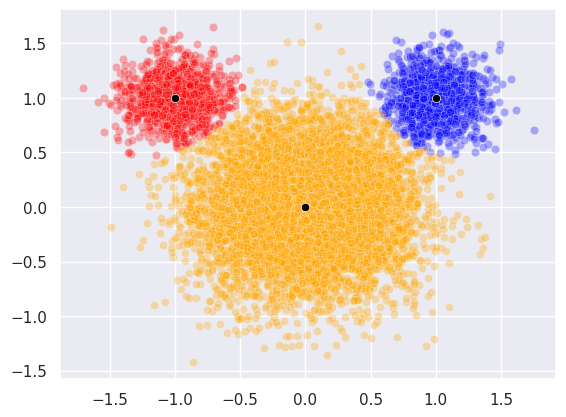

In [29]:
pred_EM=classy(soft_reg,data)
first=data[pred_EM==0]
sec=data[pred_EM==1]
third=data[pred_EM==2]
sns.scatterplot(x=first[:,0],y=first[:,1],color="red",alpha=0.3)
sns.scatterplot(x=sec[:,0],y=sec[:,1],color="blue",alpha=0.3)
sns.scatterplot(x=third[:,0],y=third[:,1],color="orange",alpha=0.3)
sns.scatterplot(x=mu[:,0],y=mu[:,1],color="black")

In [30]:
kmeans=KMeans(3,random_state=0).fit(data)

<AxesSubplot:>

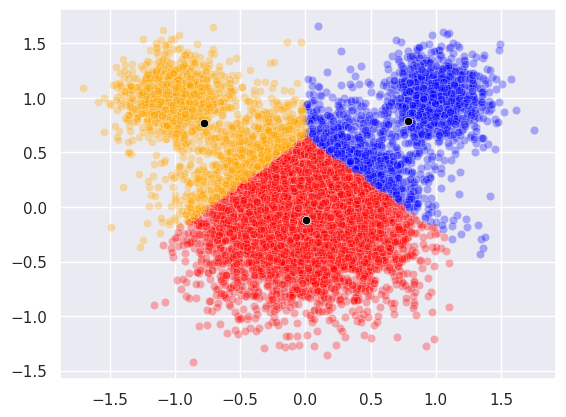

In [31]:
pred_KM=kmeans.predict(data)
first_KM=data[pred_KM==0]
sec_KM=data[pred_KM==1]
third_KM=data[pred_KM==2]
sns.scatterplot(x=first_KM[:,0],y=first_KM[:,1],color="red",alpha=0.3)
sns.scatterplot(x=sec_KM[:,0],y=sec_KM[:,1],color="blue",alpha=0.3)
sns.scatterplot(x=third_KM[:,0],y=third_KM[:,1],color="orange",alpha=0.3)
sns.scatterplot(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black")